In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from itertools import combinations
import itertools as itt

# Read the data from CSV file
path = '../data/'
data = pd.read_csv('spy_prices.csv', parse_dates=True, sep=';', index_col=[0])
data.index = pd.to_datetime(data.index)
data = data.dropna()
data.head()

,Open,High,Low,Close,Adjusted Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,26.453930,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.642057,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.698507,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.980742,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,27.093624,531500


total_number_of_days: 9877 days 00:00:00


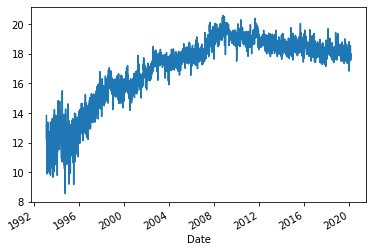

In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
print('total_number_of_days:', data.index[-1] - data.index[0]) # pandas time delta
np.log(data['Volume']).plot()

In [3]:
# Install a pip package in the current Jupyter kernel 
# import sys # <-- no need to run this if hurst is already installed
# !{sys.executable} -m pip install hurst

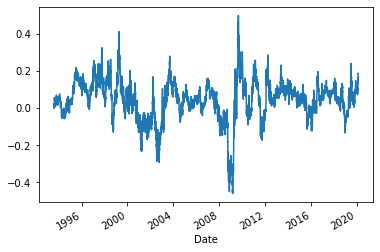

In [4]:
# Calculate and plot percentage change
data['mom126'] = data['Close'].pct_change(126)
data['mom126'].plot()

In [5]:
# creating a trading signal (long only)
# rationale: if it's been trending in the last year, and the the momentum is positive, buy SPY
# buying signal is all or nothing
mask_pos = (data.mom126 >= 0.01) 
# mask_neg = (data.mom126 <= 0.001) 
data['signal_mh'] = np.where(mask_pos, 1, 0)
#data.loc[mask_neg, 'signal_mh'] = -1
data['signal_mh'].value_counts()

1    4710
0    2101
Name: signal_mh, dtype: int64

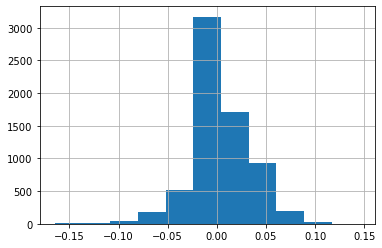

In [6]:
# strategy returns
# suppose also you hold a position for one month
# distribution seem to be negatively skewed, but with a fat right-tail
data['returns'] = data.Close.shift(-21).pct_change(21)
data['strategy_returns'] = data['returns'].mul(data.signal_mh)
data['strategy_returns'].hist(bins=11) # skewed negatively
data = data.dropna()

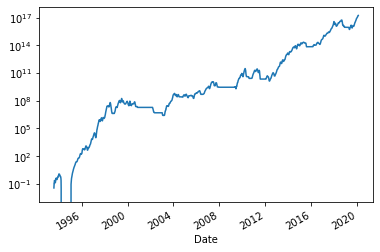

In [7]:
data['cumret'] = ((data['strategy_returns'] + 1.).cumprod() - 1)
data['cumret'].plot(logy=True)

In [8]:
# Sharpe Ratio -- use pyfolio
import pyfolio as pf
perf_func = pf.timeseries.perf_stats
perf_func(data['strategy_returns'])
# (data.returns.mean() / data.returns.std()) * np.sqrt(252)

D:\tools\anaconda\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Annual return          3.458664e+00
Cumulative returns     1.667087e+17
Annual volatility      4.602403e-01
Sharpe ratio           3.488124e+00
Calmar ratio           3.509487e+00
Stability              9.205367e-01
Max drawdown          -9.855182e-01
Omega ratio            1.938629e+00
Sortino ratio          5.614200e+00
Skew                  -3.188247e-01
Kurtosis               2.215519e+00
Tail ratio             1.201124e+00
Daily value at risk   -5.161429e-02
dtype: float64

In [9]:
def cpcv_generator(t_span, n, k, verbose=True):
    # split data into N groups, with N << T
    # this will assign each index position to a group position
    group_num = np.arange(t_span) // (t_span // n)
    group_num[group_num == n] = n-1
    
    # generate the combinations 
    test_groups = np.array(list(itt.combinations(np.arange(n), k))).reshape(-1, k)
    C_nk = len(test_groups)
    n_paths = C_nk * k // n 
    
    if verbose:
        print('n_sim:', C_nk)
        print('n_paths:', n_paths)
    
    # is_test is a T x C(n, k) array where each column is a logical array 
    # indicating which observation in in the test set
    is_test_group = np.full((n, C_nk), fill_value=False)
    is_test = np.full((t_span, C_nk), fill_value=False)
    
    # assign test folds for each of the C(n, k) simulations
    for k, pair in enumerate(test_groups):
        i, j = pair
        is_test_group[[i, j], k] = True
        
        # assigning the test folds
        mask = (group_num == i) | (group_num == j)
        is_test[mask, k] = True
        
    # for each path, connect the folds from different simulations to form a backtest path
    # the fold coordinates are: the fold number, and the simulation index e.g. simulation 0, fold 0 etc
    path_folds = np.full((n, n_paths), fill_value=np.nan)
    
    for i in range(n_paths):
        for j in range(n):
            s_idx = is_test_group[j, :].argmax().astype(int)
            path_folds[j, i] = s_idx
            is_test_group[j, s_idx] = False
            
    
    # finally, for each path we indicate which simulation we're building the path from and the time indices
    paths = np.full((t_span, n_paths), fill_value= np.nan)
    
    for p in range(n_paths):
        for i in range(n):
            mask = (group_num == i)
            paths[mask, p] = int(path_folds[i, p])
    # paths = paths_# .astype(int)

    return (is_test, paths, path_folds)    

# rule of thumb for generating backtest paths
num_ticks = 100
num_paths = 5
num_groups_test = 2
num_groups = num_paths + 1

is_test, paths, path_folds = cpcv_generator(num_ticks, num_groups, num_groups_test)

n_sim: 15
n_paths: 5


In [10]:
# paths
path_folds

array([[ 0.,  1.,  2.,  3.,  4.],
       [ 0.,  5.,  6.,  7.,  8.],
       [ 1.,  5.,  9., 10., 11.],
       [ 2.,  6.,  9., 12., 13.],
       [ 3.,  7., 10., 12., 14.],
       [ 4.,  8., 11., 13., 14.]])

In [11]:
# to read the array on the right goes from top to bottom
# backtest path 0 is formed by: fold 0 of simulation 0, fold 1 of simulation 1, 
test = np.array([[ 0.,  1.,  2.,  3.,  4.],
                [ 0.,  5.,  6.,  7.,  8.],
                [ 1.,  5.,  9., 10., 11.],
                [ 2.,  6.,  9., 12., 13.],
                [ 3.,  7., 10., 12., 14.],
                [ 4.,  8., 11., 13., 14.]])

In [12]:
assert (path_folds == test).all()
# Import compute_Hc package from hurst library
from hurst import compute_Hc
# lengthy computation
data['hurst'] = data['Close'].rolling(window=126).apply(lambda x: compute_Hc(x)[0])
data['hurst'].isna().sum() / len(data) # nearly 50% of the data gets thrown away

0.018698578908002993

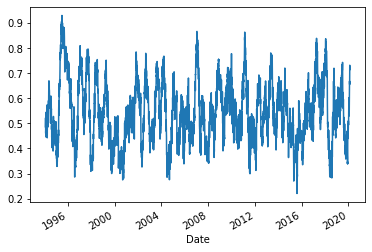

In [13]:
data['hurst'].plot()

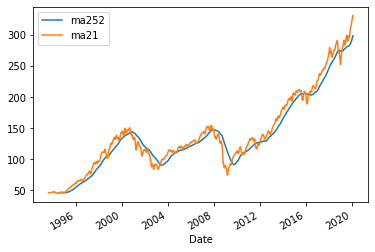

In [14]:
# let's create a few more features to implement a quantamental model
data['zscore'] = (data.Close - data.Close.rolling(126).mean())/data.Close.rolling(126).std()
data['ma21'] = data.Close.rolling(21).mean()
data['ma252'] = data.Close.rolling(262).mean()
data['vol'] = data.Close.pct_change().rolling(63).std()
# data['breakout'] = data.Close.rolling(21).min()
data[['ma252', 'ma21']].plot()

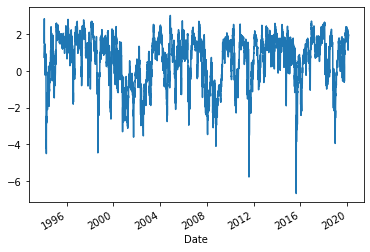

In [15]:
data['zscore'].plot()

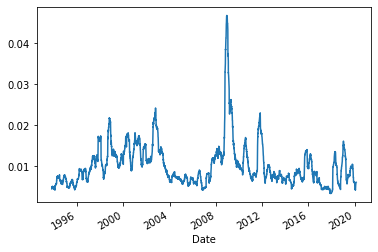

In [16]:
data['vol'].plot()

In [17]:
# features are correlated but signals are significant
feats = ['zscore', 'ma252', 'ma21', 'vol', 'hurst']
data[feats].corr()

,zscore,ma252,ma21,vol,hurst
zscore,1.000000,-0.031342,0.110986,-0.472786,0.214577
ma252,-0.031342,1.000000,0.985122,-0.133073,-0.125400
ma21,0.110986,0.985122,1.000000,-0.206961,-0.094924
vol,-0.472786,-0.133073,-0.206961,1.000000,-0.082712
hurst,0.214577,-0.125400,-0.094924,-0.082712,1.000000


In [18]:
# len(data.dropna())/len(data)

# setting up the simulation loop
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# prediction and evalution times
# using business days, but the index is not holidays aware -- it can be fixed
t1_ = data.index
# recall that we are holding our position for 21 days
# normally t1 is important is there events such as stop losses, or take profit events
t1 = pd.Series(t1_[21:], index=t1_[:-21]) # t1 is both the trade time and the event time
t1.head() # notice how the events (mark-to-market) take place 5 days later

Date
1993-07-30   1993-08-30
1993-08-02   1993-08-31
1993-08-03   1993-09-01
1993-08-04   1993-09-02
1993-08-05   1993-09-03
Name: Date, dtype: datetime64[ns]

In [19]:
# AFML, snippet 7.1

def purge(t1, test_times): # whatever is not in the train set should be in the test set
    train = t1.copy(deep=True) # copy of the index
    for start, end in tqdm(test_times.iteritems(), total=len(test_times)):
        df_0 = train[(start <= train.index) & (train.index <= end)].index # train starts within test
        df_1 = train[(start <= train) & (train <= end)].index
        df_2 = train[(train.index <= start) & (end <= train)].index
        train = train.drop(df_0.union(df_1).union(df_2))
    return train

# AFML, snippet 7.2
def embargo_(times, pct_embargo):
    step = int(times.shape[0] * pct_embargo) # more complicated logic if needed to use a time delta
    print('step:', step)
    if step == 0:
        ans = pd.Series(times, index=test_times)
    else:
        ans = pd.Series(times[step:].values, index=times[:-step].index)
        ans = ans.append(pd.Series(times[-1], index=times[-step:].index))
    return ans

def embargo(test_times, t1, pct_embargo=0.01): # done before purging
    # embargoed t1
    t1_embargo = embargo_(t1, pct_embargo)
    # test_start, test_end = test_times.index[0], test_times.index[-1]
    test_times_embargoed = t1_embargo.loc[test_times.index]
    return test_times_embargoed
data.shape

(6685, 16)

In [20]:
# let's create the labels for our algorithm
# our strategy previously did a buy or hold -- so our labels are whether those actions were profitable or not
# if we hold and the strategy goes up, that's lost money
# the idea is to use ML as a risk management tool
thold = 0.01
returns = data.Close.shift(-21).pct_change(21)
signal = data.signal_mh

# quantamental approach
mask_1 = (returns > thold) & (signal == 1) # good
mask_2 = (returns > thold) & (signal == 0) # bad
mask_3 = (returns <= thold) & (signal == 1) # bad
mask_4 = (returns <= thold) & (signal == 0) # good

# assign values
data['y'] = np.nan
data.loc[mask_1, 'y'] = 1
data.loc[mask_2, 'y'] = 0
data.loc[mask_3, 'y'] = 0
data.loc[mask_4, 'y'] = 1

# count labels
data['y'].value_counts()

1.0    3468
0.0    3196
Name: y, dtype: int64

In [21]:
# realign data
data = data.loc[t1.index]
len(data), len(t1)

(6664, 6664)

In [22]:
data = data.dropna()

# realign t1
t1 = t1.loc[data.index]
len(t1)

6403

In [23]:
num_paths = 5
num_groups_test = 2
num_groups = num_paths + 1 
num_ticks = len(data)
is_test, paths, _ = cpcv_generator(num_ticks, num_groups, num_groups_test)

n_sim: 15
n_paths: 5


In [33]:
# define some arrays to store the prediction probabilities
pred = np.full(is_test.shape, np.nan)

# defining X, y
# feats = ['zscore', 'ma21', 'ma252', 'vol', 'hurst']
X = data[feats]
y = data['y']

num_sim = is_test.shape[1] # num of simulations needed to generate all backtest paths
for k in tqdm(range(num_sim)):
    # get train set|
    test_idx = is_test[:, k] 
    
    # convert numerical indices into time stamps
    test_times = t1.loc[test_idx]
    
    # embargo
    test_times_embargoed = embargo(test_times, t1, pct_embargo=0.01)
    print(test_times.shape, type(test_times))
    print(test_times.head())
    print(t1.shape, type(t1))
    print(t1.head())
    break
    
    print("Purging...")
    print(t1.shape, test_times_embargoed.shape)
    # purge
    train_times = purge(t1, test_times_embargoed)
    
    # split training / test sets
    X_test = X.loc[test_times.index, :]
    y_test = y.loc[X_test.index]
    
    X_train = X.loc[train_times.index, :]
    y_train = y.loc[X_train.index]
    
    # reconstructing the backtest paths
    print('training classifier for simulation %s' % k)
    np.random.seed(42)
    base_est = DecisionTreeClassifier(criterion='entropy', 
                                      max_features='auto', 
                                      class_weight='balanced', 
                                      min_weight_fraction_leaf=0.05)
    clf = BaggingClassifier(base_estimator=base_est, n_estimators=50, max_features=.99)
    clf.fit(X_train, y_train)
    pred_ = clf.predict(X_test)
    
    # fill the backtesting prediction matrix
    pred[test_idx, k] = pred_

step: 64
(2134,) <class 'pandas.core.series.Series'>
Date
1994-08-11   1994-09-12
1994-08-12   1994-09-13
1994-08-15   1994-09-14
1994-08-16   1994-09-15
1994-08-17   1994-09-16
Name: Date, dtype: datetime64[ns]
(6403,) <class 'pandas.core.series.Series'>
Date
1994-08-11   1994-09-12
1994-08-12   1994-09-13
1994-08-15   1994-09-14
1994-08-16   1994-09-15
1994-08-17   1994-09-16
Name: Date, dtype: datetime64[ns]



In [25]:
backtest_paths = np.full((X.shape[0], paths.shape[1]), np.nan)
old_signal = data['signal_mh'].loc[X.index]
ret = data['returns'].loc[X.index]

for p in range(paths.shape[1]):
    for t, k in enumerate(paths[:, p]):
        backtest_paths[t, p] = ( bool(pred[t, int(k)]) &  bool(old_signal[t]) ) * ret[t]
        
import pyfolio as pf
perf_func = pf.timeseries.perf_stats

perf_list = []
for s in range(paths.shape[1]):
    perf_table = perf_func(backtest_paths[:, s])
    perf_list.append(perf_table)
    
perf_paths = pd.concat(perf_list, axis=1)
perf_paths

,0,1,2,3,4
Annual return,3.707969e+00,3.707969e+00,3.707969e+00,3.707969e+00,3.707969e+00
Cumulative returns,1.246947e+17,1.246947e+17,1.246947e+17,1.246947e+17,1.246947e+17
Annual volatility,4.670288e-01,4.670288e-01,4.670288e-01,4.670288e-01,4.670288e-01
Sharpe ratio,3.561394e+00,3.561394e+00,3.561394e+00,3.561394e+00,3.561394e+00
Calmar ratio,3.762457e+00,3.762457e+00,3.762457e+00,3.762457e+00,3.762457e+00
Stability,9.173160e-01,9.173160e-01,9.173160e-01,9.173160e-01,9.173160e-01
Max drawdown,-9.855182e-01,-9.855182e-01,-9.855182e-01,-9.855182e-01,-9.855182e-01
Omega ratio,1.954484e+00,1.954484e+00,1.954484e+00,1.954484e+00,1.954484e+00
Sortino ratio,5.740543e+00,5.740543e+00,5.740543e+00,5.740543e+00,5.740543e+00
Skew,-3.297245e-01,-3.297245e-01,-3.297245e-01,-3.297245e-01,-3.297245e-01


In [26]:
perf_paths.loc['Sharpe ratio', :].mean()

3.561393603709024

In [27]:
perf_paths.loc['Sharpe ratio', :].std()

0.0

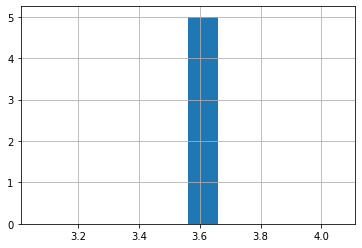

In [28]:
perf_paths.loc['Sharpe ratio', :].hist()

In [29]:
perf_paths.loc['Max drawdown', :].mean() # slightly better than the base strategy -- but still very risky

-0.985518188564454

In [30]:
perf_paths.loc['Max drawdown', :].std()

0.0

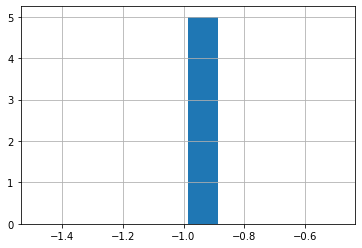

In [31]:
perf_paths.loc['Max drawdown', :].hist()